<h1>Data Science Capstone Project</h1>
This Notebook is used for the final capstone project

<h1>Topic: Where to live in Vancouver?</h1>

<h2>Part 1: Create a list of neighborhoods in Vancouver and get their coordinates</h2>

In [1]:
import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import requests
print("Libraries imported.")

Libraries imported.


In [2]:
column_names = ["Neighborhood", "Latitude", "Longitude"] 
areas = ["Arbutus Ridge", "Downtown", "Dunbar-Southlands", "Fairview", "Grandview-Woodland", "Hastings-Sunrise", "Kensington-Cedar Cottage", 
         "Kerrisdale", "Killarney", "Kitsilano", "Marpole", "Mount Pleasant", "Oakridge", "Renfrew-Collingwood", "Riley Park", "Shaughnessy", 
         "South Cambie", "Strathcona", "Sunset", "Victoria-Fraserview", "West End", "West Point Grey"]

In [3]:
neighborhoods = pd.DataFrame(columns=column_names)
geolocator = Nominatim(user_agent="foursquare_agent")
for area in areas:
    address = area + ", Vancouver, BC, Canada"
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    neighborhoods = neighborhoods.append({'Neighborhood': area,
                                          'Latitude': latitude,
                                          'Longitude': longitude}, ignore_index=True)
neighborhoods.head(len(areas))

,Neighborhood,Latitude,Longitude
0,Arbutus Ridge,49.246305,-123.159636
1,Downtown,49.283393,-123.117456
2,Dunbar-Southlands,49.237864,-123.184354
3,Fairview,49.261956,-123.130408
4,Grandview-Woodland,49.275849,-123.066934
5,Hastings-Sunrise,49.277830,-123.040005
6,Kensington-Cedar Cottage,49.246790,-123.073475
7,Kerrisdale,49.220985,-123.159548
8,Killarney,49.218012,-123.037115
9,Kitsilano,49.269410,-123.155267


In [4]:
neighborhoods.to_csv("vancouver_neighborhood.csv", index=False)

To make it convenient to re-use later, the file "vancouver_neighborhood.csv" is uploaded to GitHub and is available at https://raw.githubusercontent.com/uclinux83/Coursera_Capstone/master/vancouver_neighborhood.csv

<h2>Part 2: Get Foursquare data for each neighborhood</h2>

Import libraries again

In [1]:
import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import requests
print("Libraries imported.")

Libraries imported.


Load Vancouver neighborhoods from CSV file:

In [2]:
neighborhoods = pd.read_csv("https://raw.githubusercontent.com/uclinux83/Coursera_Capstone/master/vancouver_neighborhood.csv")
neighborhoods.head()

,Neighborhood,Latitude,Longitude
0,Arbutus Ridge,49.246305,-123.159636
1,Downtown,49.283393,-123.117456
2,Dunbar-Southlands,49.237864,-123.184354
3,Fairview,49.261956,-123.130408
4,Grandview-Woodland,49.275849,-123.066934


Define the list of 9 criteria and their corresponding category ID. The category ID list can be found at https://developer.foursquare.com/docs/build-with-foursquare/categories/:

In [3]:
criteria_list = {"Entertainment":"4d4b7104d754a06370d81259", "Education":"4d4b7105d754a06372d81259,4bf58dd8d48988d13b941735",
                "Food":"4d4b7105d754a06374d81259", "Nightlife": "4d4b7105d754a06376d81259", "Outdoor": "4d4b7105d754a06377d81259",
                "Healthcare":"4bf58dd8d48988d104941735", "Religion":"4bf58dd8d48988d131941735", "Shop":"4d4b7105d754a06378d81259",
                "Transportation":"4bf58dd8d48988d129951735,52f2ab2ebcbc57f1066b8b4f,4bf58dd8d48988d1fe931735,4bf58dd8d48988d12d951735"}
for criteria in criteria_list:
    print("Categories IDs of " + criteria + " criteria are: " + criteria_list[criteria])

Categories IDs of Entertainment criteria are: 4d4b7104d754a06370d81259
Categories IDs of Education criteria are: 4d4b7105d754a06372d81259,4bf58dd8d48988d13b941735
Categories IDs of Food criteria are: 4d4b7105d754a06374d81259
Categories IDs of Nightlife criteria are: 4d4b7105d754a06376d81259
Categories IDs of Outdoor criteria are: 4d4b7105d754a06377d81259
Categories IDs of Healthcare criteria are: 4bf58dd8d48988d104941735
Categories IDs of Religion criteria are: 4bf58dd8d48988d131941735
Categories IDs of Shop criteria are: 4d4b7105d754a06378d81259
Categories IDs of Transportation criteria are: 4bf58dd8d48988d129951735,52f2ab2ebcbc57f1066b8b4f,4bf58dd8d48988d1fe931735,4bf58dd8d48988d12d951735


Now come the most important data collection step: Get the venues around each neighborhood. Since each neighborhood is quite small, a radius of 2km (2,000 meters) is sufficient to cover the whole neighborhood:

In [6]:
CLIENT_ID = 'XXX' # Hide before uploading to GitHub
CLIENT_SECRET = 'XXX' # Hide before uploading to GitHub
ACCESS_TOKEN = 'XXX' # Hide before uploading to GitHub
VERSION = '20201220'
LIMIT = 50 # Foursquare maximum limit
RADIUS = 2000 # A radius of 2,000 meters is sufficient enough to cover the whole neighborhood

venues_list=[]
for name, lat, lng in zip(neighborhoods["Neighborhood"], neighborhoods["Latitude"], neighborhoods["Longitude"]):
    for criteria in criteria_list:
        print("Processing " + name + " with criteria " + criteria)
        categories = criteria_list[criteria]
        result_size = LIMIT
        offset = 0
        
        # Keep calling the API to get all venues, until the size of the results is less than LIMIT
        while result_size == LIMIT:
            # create the API request URL
            print("Call with offset = " + str(offset))
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&offset={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                RADIUS,
                categories,
                offset,
                LIMIT)
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name,
                criteria,
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

            # Set value for result_size and offset
            offset = offset + LIMIT
            result_size = len(results)
            print("Result size is " + str(result_size))

nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['Neighborhood',
                  'Criteria',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']


Processing Arbutus Ridge with criteria Entertainment
Call with offset = 0
Result size is 2
Processing Arbutus Ridge with criteria Education
Call with offset = 0
Result size is 14
Processing Arbutus Ridge with criteria Food
Call with offset = 0
Result size is 50
Call with offset = 50
Result size is 22
Processing Arbutus Ridge with criteria Nightlife
Call with offset = 0
Result size is 4
Processing Arbutus Ridge with criteria Outdoor
Call with offset = 0
Result size is 28
Processing Arbutus Ridge with criteria Healthcare
Call with offset = 0
Result size is 21
Processing Arbutus Ridge with criteria Religion
Call with offset = 0
Result size is 8
Processing Arbutus Ridge with criteria Shop
Call with offset = 0
Result size is 48
Processing Arbutus Ridge with criteria Transportation
Call with offset = 0
Result size is 11
Processing Downtown with criteria Entertainment
Call with offset = 0
Result size is 50
Call with offset = 50
Result size is 17
Processing Downtown with criteria Education
Cal

Result size is 31
Processing Killarney with criteria Nightlife
Call with offset = 0
Result size is 6
Processing Killarney with criteria Outdoor
Call with offset = 0
Result size is 17
Processing Killarney with criteria Healthcare
Call with offset = 0
Result size is 9
Processing Killarney with criteria Religion
Call with offset = 0
Result size is 4
Processing Killarney with criteria Shop
Call with offset = 0
Result size is 43
Processing Killarney with criteria Transportation
Call with offset = 0
Result size is 9
Processing Kitsilano with criteria Entertainment
Call with offset = 0
Result size is 33
Processing Kitsilano with criteria Education
Call with offset = 0
Result size is 25
Processing Kitsilano with criteria Food
Call with offset = 0
Result size is 50
Call with offset = 50
Result size is 50
Call with offset = 100
Result size is 50
Call with offset = 150
Result size is 5
Processing Kitsilano with criteria Nightlife
Call with offset = 0
Result size is 36
Processing Kitsilano with cr

Result size is 50
Call with offset = 50
Result size is 50
Call with offset = 100
Result size is 50
Call with offset = 150
Result size is 12
Processing Strathcona with criteria Nightlife
Call with offset = 0
Result size is 50
Call with offset = 50
Result size is 24
Processing Strathcona with criteria Outdoor
Call with offset = 0
Result size is 50
Call with offset = 50
Result size is 48
Processing Strathcona with criteria Healthcare
Call with offset = 0
Result size is 35
Processing Strathcona with criteria Religion
Call with offset = 0
Result size is 12
Processing Strathcona with criteria Shop
Call with offset = 0
Result size is 50
Call with offset = 50
Result size is 41
Processing Strathcona with criteria Transportation
Call with offset = 0
Result size is 50
Call with offset = 50
Result size is 15
Processing Sunset with criteria Entertainment
Call with offset = 0
Result size is 3
Processing Sunset with criteria Education
Call with offset = 0
Result size is 25
Processing Sunset with crit

In [8]:
nearby_venues.head()

,Neighborhood,Criteria,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arbutus Ridge,Entertainment,Dunbar Theater,49.245613,-123.185428,Indie Movie Theater
1,Arbutus Ridge,Entertainment,Dance Co,49.248822,-123.154979,Dance Studio
2,Arbutus Ridge,Education,Point Grey Secondary,49.237441,-123.153967,School
3,Arbutus Ridge,Education,Carnarvon Community School,49.256532,-123.173862,School
4,Arbutus Ridge,Education,St. John's School,49.262445,-123.153701,School


Let's save the data to a CSV file for later use

In [9]:
nearby_venues.to_csv("vancouver_venues_details.csv", index=False)

This CSV file has been uploaded to GitHub and available at https://raw.githubusercontent.com/uclinux83/Coursera_Capstone/master/vancouver_venues_details.csv

<h2>Part 3: Create a summary dataframe to make it easier to calculate score for the neighborhood</h2>

Import libraries

In [1]:
import numpy as np
import pandas as pd

Load data from the CSV file that we just created in the previous part:

In [2]:
venues = pd.read_csv("https://raw.githubusercontent.com/uclinux83/Coursera_Capstone/master/vancouver_venues_details.csv")
venues.head()

,Neighborhood,Criteria,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arbutus Ridge,Entertainment,Dunbar Theater,49.245613,-123.185428,Indie Movie Theater
1,Arbutus Ridge,Entertainment,Dance Co,49.248822,-123.154979,Dance Studio
2,Arbutus Ridge,Education,Point Grey Secondary,49.237441,-123.153967,School
3,Arbutus Ridge,Education,Carnarvon Community School,49.256532,-123.173862,School
4,Arbutus Ridge,Education,St. John's School,49.262445,-123.153701,School


Check the size:

In [3]:
venues.shape

(8811, 6)

Create a dataframe to store summary venues data

In [4]:
neighborhoods = venues["Neighborhood"].unique()
criteria_list = venues["Criteria"].unique()
data = {"Neighborhood": neighborhoods}
for criteria in criteria_list:
    counters = []
    for neighborhood in neighborhoods:
        count = venues[(venues["Neighborhood"] == neighborhood) & (venues["Criteria"] == criteria)].shape[0]
        counters.append(count)
    data[criteria] = counters

neighborhood_summary = pd.DataFrame(data)
neighborhood_summary.head(len(neighborhood_summary))

,Neighborhood,Entertainment,Education,Food,Nightlife,Outdoor,Healthcare,Religion,Shop,Transportation
0,Arbutus Ridge,2,14,72,4,28,21,8,43,11
1,Downtown,70,93,249,169,148,61,20,184,111
2,Dunbar-Southlands,7,5,31,5,16,4,5,33,4
3,Fairview,44,53,174,60,99,67,12,129,72
4,Grandview-Woodland,11,27,118,30,46,26,9,71,31
5,Hastings-Sunrise,8,16,79,12,31,14,10,50,26
6,Kensington-Cedar Cottage,5,19,150,6,35,29,9,39,46
7,Kerrisdale,5,5,59,5,18,9,6,57,15
8,Killarney,3,8,31,6,17,9,4,43,9
9,Kitsilano,33,25,155,36,86,34,5,119,55


Let's sort the neighborhoods on each criteria and draw some charts:

Import the required libraries first:

In [5]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

Sort on Entertainment criteria and draw the bar chart:

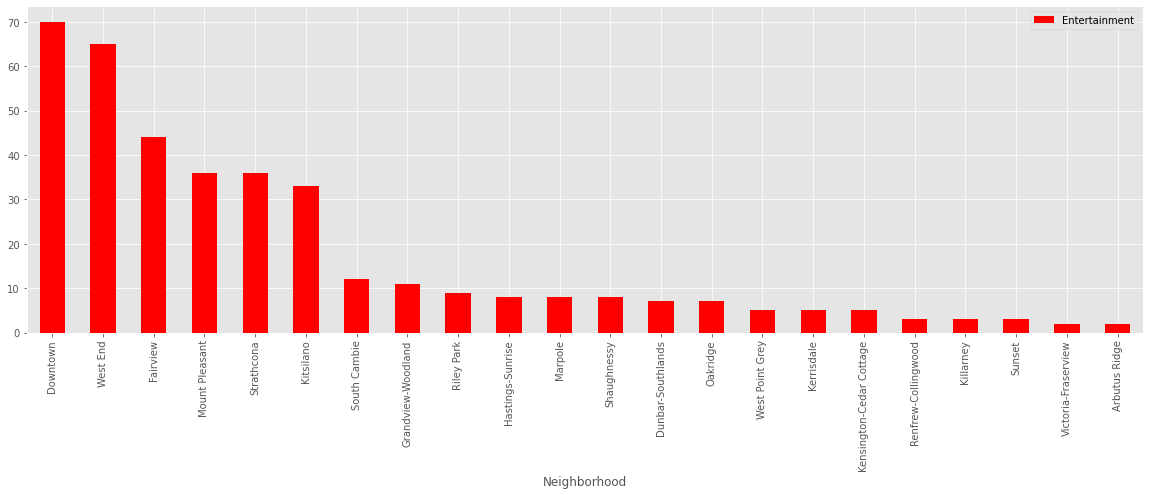

In [6]:
df_chart = neighborhood_summary.sort_values(["Entertainment"], ascending=False, axis=0, inplace=True)
df_chart = (pd.DataFrame([neighborhood_summary["Neighborhood"], neighborhood_summary["Entertainment"]])).transpose()
df_chart.set_index("Neighborhood", inplace=True)
df_chart.plot(kind='bar', color='red', figsize=(20, 6))

How about ranking in Education category:

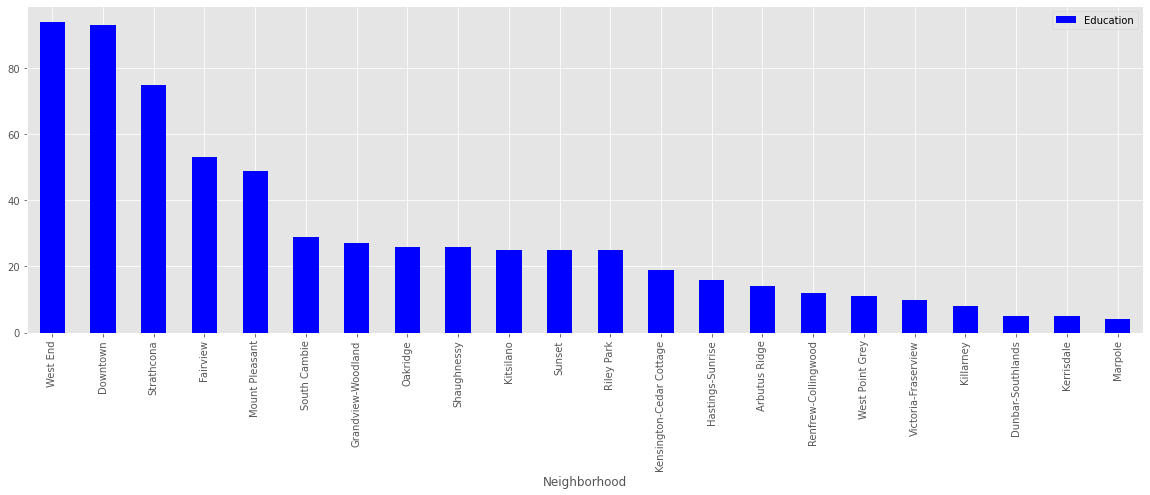

In [8]:
df_chart = neighborhood_summary.sort_values(["Education"], ascending=False, axis=0, inplace=True)
df_chart = (pd.DataFrame([neighborhood_summary["Neighborhood"], neighborhood_summary["Education"]])).transpose()
df_chart.set_index("Neighborhood", inplace=True)
df_chart.plot(kind='bar', color='blue', figsize=(20, 6))

How about Food?

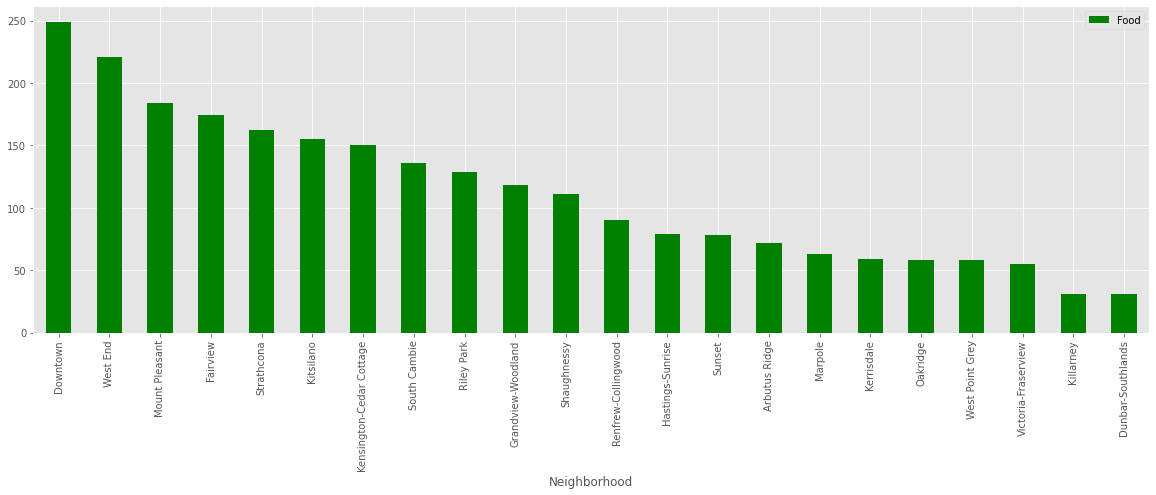

In [9]:
df_chart = neighborhood_summary.sort_values(["Food"], ascending=False, axis=0, inplace=True)
df_chart = (pd.DataFrame([neighborhood_summary["Neighborhood"], neighborhood_summary["Food"]])).transpose()
df_chart.set_index("Neighborhood", inplace=True)
df_chart.plot(kind='bar', color='green', figsize=(20, 6))

We can follow the same approach to create chart for each of the 9 criteria

Now save this summary dataframe to a CSV file for convenient usage later:

In [10]:
neighborhood_summary.to_csv("vancouver_venues_summary.csv", index=False)

This CSV file has also been uploaded to GitHub and available at https://raw.githubusercontent.com/uclinux83/Coursera_Capstone/master/vancouver_venues_summary.csv

<h2>Part 4: Take user's preferences, calculate score for each neighborhood and give recommendation</h2>

Import required libraries:

In [11]:
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

Load data from the CSV file (vancouver_venues_summary.csv) that we just created from the previous part:

In [12]:
neighborhood_summary = pd.read_csv("https://raw.githubusercontent.com/uclinux83/Coursera_Capstone/master/vancouver_venues_summary.csv")
neighborhood_summary.head()

,Neighborhood,Entertainment,Education,Food,Nightlife,Outdoor,Healthcare,Religion,Shop,Transportation
0,Arbutus Ridge,2,14,72,4,28,21,8,43,11
1,Downtown,70,93,249,169,148,61,20,184,111
2,Dunbar-Southlands,7,5,31,5,16,4,5,33,4
3,Fairview,44,53,174,60,99,67,12,129,72
4,Grandview-Woodland,11,27,118,30,46,26,9,71,31


Now we can take the user's preference by giving weight to each criteria. For example, the following user's preference gives the same weight (1) to all criteria:

In [13]:
preference = {"Entertainment": 1, "Education": 1, "Food": 1, "Nightlife": 1, "Outdoor": 1, 
           "Healthcare": 1, "Religion": 1, "Shop": 1, "Transportation": 1}

We can calculate score for each neighborhood and rank them:

In [15]:
score_list = []
for i in neighborhood_summary.index:
    score = 0
    for criteria in preference:
        score += neighborhood_summary[criteria][i] * preference[criteria]
    score_list.append(score)
neighborhood_summary["Score"] = score_list
neighborhood_summary.sort_values(by=["Score"], ascending=False, inplace=True)
neighborhood_summary.head(len(neighborhood_summary))

,Neighborhood,Entertainment,Education,Food,Nightlife,Outdoor,Healthcare,Religion,Shop,Transportation,Score
1,Downtown,70,93,249,169,148,61,20,184,111,1105
20,West End,65,94,221,164,142,68,16,191,113,1074
3,Fairview,44,53,174,60,99,67,12,129,72,710
11,Mount Pleasant,36,49,184,56,79,43,22,109,66,644
17,Strathcona,36,75,162,74,96,35,12,85,69,644
9,Kitsilano,33,25,155,36,86,34,5,119,55,548
16,South Cambie,12,29,136,16,50,52,18,87,42,442
14,Riley Park,9,25,129,19,49,48,19,78,44,420
4,Grandview-Woodland,11,27,118,30,46,26,9,71,31,369
6,Kensington-Cedar Cottage,5,19,150,6,35,29,9,39,46,338


Visualize the rankings using bar chart:

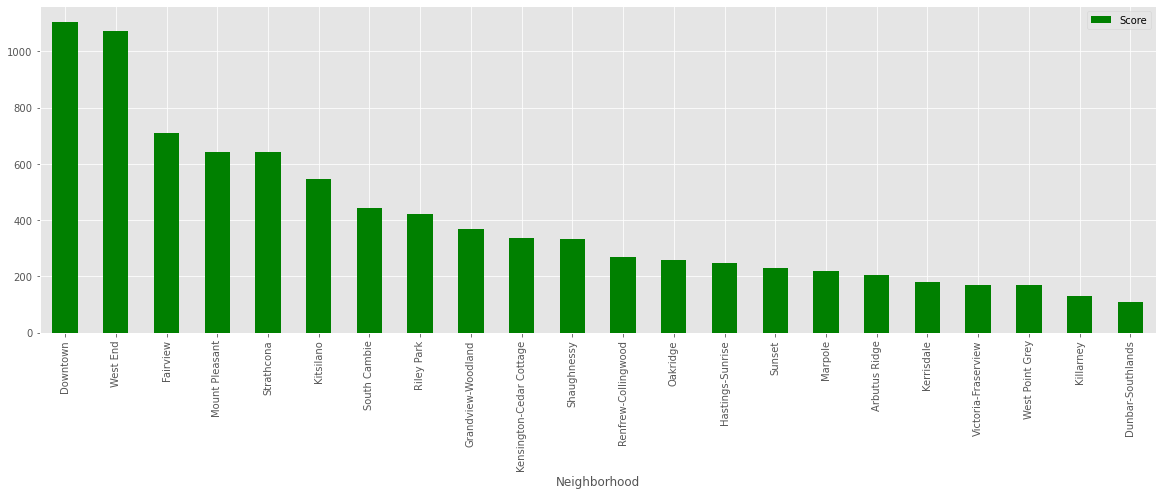

In [17]:
df_chart = neighborhood_summary.sort_values(["Score"], ascending=False, axis=0, inplace=True)
df_chart = (pd.DataFrame([neighborhood_summary["Neighborhood"], neighborhood_summary["Score"]])).transpose()
df_chart.set_index("Neighborhood", inplace=True)
df_chart.plot(kind='bar', color='green', figsize=(20, 6))

Let's set another preference. Some users may not care about some criteria and set them to 0:

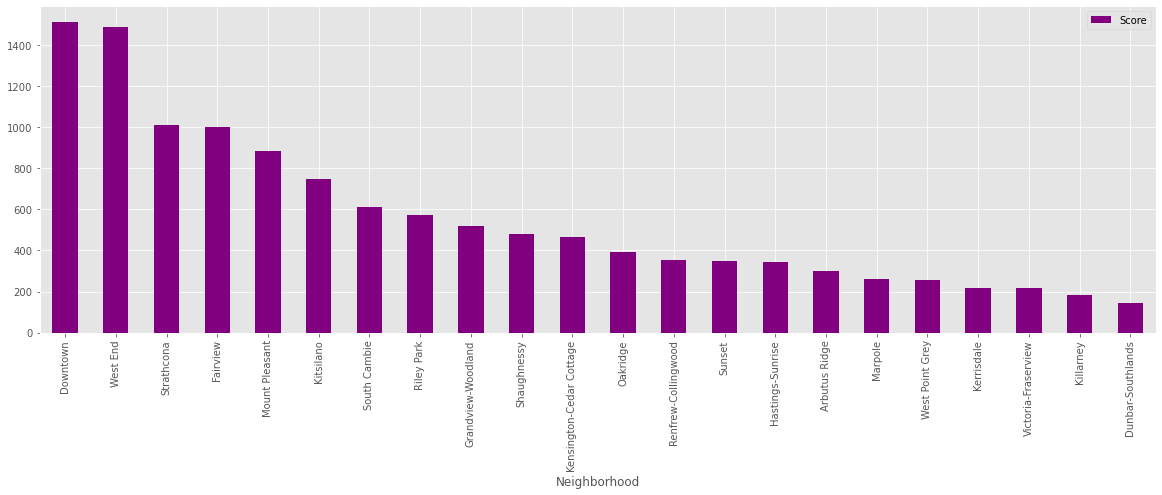

In [21]:
preference = {"Entertainment": 0, "Education": 5, "Food": 1, "Nightlife": 0, "Outdoor": 3, 
           "Healthcare": 1, "Religion": 0, "Shop": 1, "Transportation": 1}
score_list = []
for i in neighborhood_summary.index:
    score = 0
    for criteria in preference:
        score += neighborhood_summary[criteria][i] * preference[criteria]
    score_list.append(score)
neighborhood_summary["Score"] = score_list
neighborhood_summary.sort_values(by=["Score"], ascending=False, inplace=True)
df_chart = neighborhood_summary.sort_values(["Score"], ascending=False, axis=0, inplace=True)
df_chart = (pd.DataFrame([neighborhood_summary["Neighborhood"], neighborhood_summary["Score"]])).transpose()
df_chart.set_index("Neighborhood", inplace=True)
df_chart.plot(kind='bar', color='purple', figsize=(20, 6))

One more user's preference. This time with negative weight, since some people may dislike a specific category:

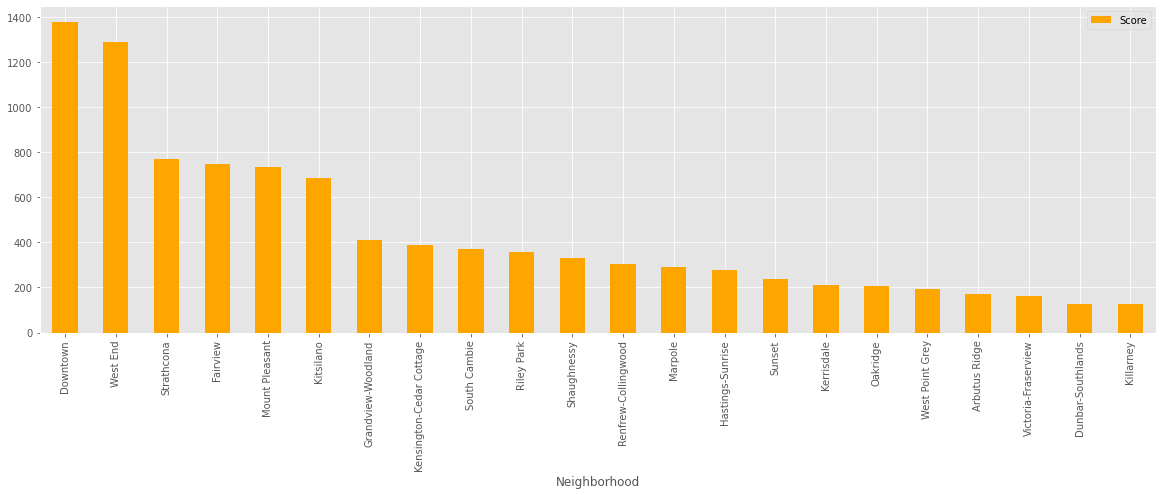

In [22]:
preference = {"Entertainment": 3, "Education": 0, "Food": 2, "Nightlife": 2, "Outdoor": 1, 
           "Healthcare": -3, "Religion": -2, "Shop": 1, "Transportation": 2}
score_list = []
for i in neighborhood_summary.index:
    score = 0
    for criteria in preference:
        score += neighborhood_summary[criteria][i] * preference[criteria]
    score_list.append(score)
neighborhood_summary["Score"] = score_list
neighborhood_summary.sort_values(by=["Score"], ascending=False, inplace=True)
df_chart = neighborhood_summary.sort_values(["Score"], ascending=False, axis=0, inplace=True)
df_chart = (pd.DataFrame([neighborhood_summary["Neighborhood"], neighborhood_summary["Score"]])).transpose()
df_chart.set_index("Neighborhood", inplace=True)
df_chart.plot(kind='bar', color='orange', figsize=(20, 6))

<h3>We can apply the same approach to rank and recommend Vancouver neighborhoods for any specific preference</h3>

<h1>---------------- END OF NOTEBOOK ---------------------</h1>